# 순방향 신경망 이해
완전연결 신경망 과 합성곱 신경망은 메모리가 존재하지않음.  
입력은 각각 개별처리되며 입력 간 유지되는 상태가 없음.  
이런 신경망 모델로 입력값을 처리하려면 모델에 전체 시퀀스를 주입해야한다. 전체 시퀀스를 하나의 데이터 포인트로 입력해야한다는 뜻  
예를 들면 앞서 사용한 5일치 데이터가 하나의 벡터로 만들어 처리한 점이다.  
이런 모델을 **피드포워드 신경망**이라고 함.(순환하지 않는 신경망=>**순방향 신경망**)  
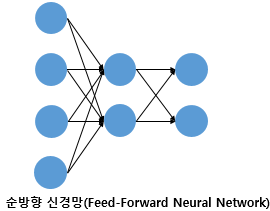

## 케라스의 simpleRNN 구현
numpy처럼 하나의 시퀀스가 아닌 시퀀스의 배치를 처리함.  
(timestep,input)의 형식이 아니라 (batch_size,timestep,input)크기 입력을 받음.  
(timestep매개변수에 None으로 설정해 임의의 길이를 가진 시퀀스 처리 가능)

In [28]:
num_features=14
model=keras.Sequential()
model.add(keras.Input(shape=(None,num_features))) # 타임스탭 부분을 none으로 임의 설정
model.add(keras.layers.SimpleRNN(16))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


### 마지막 출력스텝만 리턴하는 모델

In [32]:
steps=120
model2=keras.Sequential()
model2.add(keras.Input(shape=(steps,num_features)))
model2.add(keras.layers.SimpleRNN(16,return_sequences=False)) # false가 디폴트
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 16)                496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


### 전체 상태를 리턴하는 모델

In [33]:
model3=keras.Sequential()
model3.add(keras.Input(shape=(steps,num_features)))
model3.add(keras.layers.SimpleRNN(16,return_sequences=True))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 120, 16)           496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


### 스태킹 RNN 모델
신경망의 표현을 증가시키기 위해 여러개의 순환층을 쌓음. 이런 경우, 중간층의 시퀀스를 전부 반환하도록 해야함(return_sequences=True로 설정)

In [35]:
model4=keras.Sequential()
model4.add(keras.Input(shape=(steps,num_features)))
model4.add(keras.layers.SimpleRNN(16,return_sequences=True))
model4.add(keras.layers.SimpleRNN(16,return_sequences=True))
model4.add(keras.layers.SimpleRNN(16))
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 120, 16)           496       
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 120, 16)           528       
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 16)                528       
                                                                 
Total params: 1,552
Trainable params: 1,552
Non-trainable params: 0
_________________________________________________________________


In [19]:
import numpy as np

In [20]:
raw_std=np.load('dataset.npy')

In [21]:
raw_std

array([[ 0.91365151, -1.92064015, -1.97449272, ..., -0.73016651,
        -0.77935289, -0.28119316],
       [ 0.91953033, -1.96510495, -2.01848295, ..., -0.93230685,
        -0.88696976, -0.46989368],
       [ 0.91482727, -1.97650618, -2.0297625 , ..., -1.27790162,
        -1.26147647, -0.05638329],
       ...,
       [ 1.30165361, -1.36654038, -1.45450563, ..., -0.69756323,
        -0.67173602,  0.45147737],
       [ 1.30047784, -1.48853354, -1.57519677, ..., -0.43021634,
        -0.60286122,  0.57494808],
       [ 1.30165361, -1.5558008 , -1.64061814, ..., -0.59975339,
        -0.68895472,  0.09853751]])

In [22]:
import os
fname=os.path.join('data/series/jena_climate_2009_2016.csv')

with open(fname) as f:
    data=f.read()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [23]:
temp=np.zeros((len(lines),))
raw_d=np.zeros((len(lines),len(header)-1))

In [24]:
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    temp[i]=values[1] # 두번째 열을 temp에 저장
    raw_d[i,:]=values[:] # 모든 열을 raw_d에 저장

In [25]:
tr_sample=int(len(raw_d)*0.5)
val_sample=int(len(raw_d)*0.25)
te_sample=len(raw_d)-tr_sample-val_sample

print("Train_date : {0}".format(tr_sample))
print("Val_date : {0}".format(val_sample))
print("Test_date : {0}".format(te_sample))

Train_date : 210225
Val_date : 105112
Test_date : 105114


해당 데이터는 0번째에 컬럼명,1번째 이후부터 데이터가 들어있음

In [26]:
lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [27]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_std[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=tr_sample)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_std[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=tr_sample,
    end_index=tr_sample + val_sample)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_std[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=tr_sample + val_sample)